<a href="https://colab.research.google.com/github/cdbm/F1DataAnalysis/blob/master/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação 
o seguinte notebook foi feito para fazer predições usando modelos de classificação em cima do dataset da fórmula 1. Escolhemos o dataset de resultados, que contém os resultados de cada piloto em todas as corridas, para fazer nossa classificação. Para a classificação escolhemos a columa positions, que define em que posição o piloto terminou a corrida.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results=pd.read_csv("https://raw.githubusercontent.com/cdbm/F1DataAnalysis/master/f1_data/results.csv")
races=pd.read_csv("https://raw.githubusercontent.com/cdbm/F1DataAnalysis/master/f1_data/races.csv")

Limpando o dataset para ter apenas pilotos que de fato terminaram as corridas.

In [3]:
results = results[results.position != '\\N']
results = results[results.milliseconds != '\\N']

O código a seguir foi feito para tornar mais possível a classificação. Como depois da limpeza restam poucas linhas (aproximadamente 6 mil) e o dataset não tem tantas features que podem ser usadas para o modelo e existem muitas classes possíveis para se predizer (19), resolvemos então transformar as 19 classes que seriam cada posição de chegada em classes mais abrangentes. O nosso modelo agora busca classificar entre as quatro classes de posições que um piloto pode chegar, entre os 5 primeiros, entre o 6º e o 10º, entre o 11º e o 15º e entre o 16º e 19º.

In [4]:
results.position = results.position.astype('int64')

In [5]:
results.loc[results['position'] <= 5, 'beans'] = 'TOP5'
results.loc[(results['position'] > 5) & (results['position'] <= 10) , 'beans'] = 'SIX_TO_TEN'
results.loc[(results['position'] > 10) & (results['position'] <= 15) , 'beans'] = 'EL_TO_FIFTEEN'
results.loc[(results['position'] > 15) & (results['position'] <= 20) , 'beans'] = 'SIXTEEN_TO_TWENTY'

Adicionando a informação de qual circuito foi o dado resultado


In [6]:
results["circuitId"] = results.raceId.map(races.set_index('raceId')['circuitId'])

In [7]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,beans,circuitId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,TOP5,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,TOP5,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,TOP5,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,TOP5,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,TOP5,1


Dropando features que ou não podem ser usadas, ou não são úteis ou são úteis até demais para o modelo.

In [8]:
results = results.drop('number', axis=1)
results = results.drop('statusId', axis=1)
results = results.drop('time', axis=1)
results = results.drop('fastestLapTime', axis=1)
results = results.drop('positionOrder', axis=1)
results = results.drop('positionText', axis=1)
results = results.drop('resultId', axis=1)
results = results.drop('fastestLapSpeed', axis=1)
results = results.drop('rank', axis=1)
results = results.drop('fastestLap',axis=1)

In [9]:
results = results.drop('position', axis=1)

Definição de tipos

In [10]:
results.milliseconds = results.milliseconds.astype('int64')
results.beans = results.beans.astype('category')

In [11]:
results.dtypes

raceId              int64
driverId            int64
constructorId       int64
grid                int64
points            float64
laps                int64
milliseconds        int64
beans            category
circuitId           int64
dtype: object

# Divisão do dataset em treinamento validação e teste

In [15]:
from sklearn.model_selection import train_test_split
features_results = results.drop('beans', axis=1)
labels_results = results['beans']

In [16]:
features_results

,raceId,driverId,constructorId,grid,points,laps,milliseconds,circuitId
0,18,1,1,1,10.0,58,5690616,1
1,18,2,2,5,8.0,58,5696094,1
2,18,3,3,7,6.0,58,5698779,1
3,18,4,4,11,5.0,58,5707797,1
4,18,5,1,3,4.0,58,5708630,1
...,...,...,...,...,...,...,...,...
24711,1035,20,6,11,0.0,52,4855363,9
24712,1035,832,1,12,0.0,52,4856063,9
24720,1036,1,131,1,25.0,66,5505279,4
24721,1036,830,9,3,18.0,66,5529456,4


In [17]:
labels_results

0                 TOP5
1                 TOP5
2                 TOP5
3                 TOP5
4                 TOP5
             ...      
24711    EL_TO_FIFTEEN
24712    EL_TO_FIFTEEN
24720             TOP5
24721             TOP5
24722             TOP5
Name: beans, Length: 6452, dtype: category
Categories (4, object): ['EL_TO_FIFTEEN', 'SIXTEEN_TO_TWENTY', 'SIX_TO_TEN', 'TOP5']

In [18]:
feature_train, feature_test, label_train, label_test = train_test_split(features_results, labels_results, test_size=0.2,random_state=1)
feature_train, feature_validation, label_train, label_validation =  train_test_split(feature_train, label_train, test_size=0.25,random_state=1)

In [19]:
print(feature_train.shape)
print(feature_test.shape)
print(feature_validation.shape)

(3870, 8)
(1291, 8)
(1291, 8)


Dicionário para guardar as métricas


In [20]:
stats = {}

# MLFLOW


In [21]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

     |████████████████████████████████| 13.9MB 307kB/s 
     |████████████████████████████████| 153kB 46.6MB/s 
     |████████████████████████████████| 163kB 40.8MB/s 
     |████████████████████████████████| 1.1MB 46.5MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 337kB 37.2MB/s 
     |████████████████████████████████| 204kB 31.9MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 133kB 38.1MB/s 
     |████████████████████████████████| 2.6MB 51.1MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
MLflow Tracking UI: https://0a8a4a4276bc.ngrok.io


# Criação, treinamento e avaliação dos modelos

Modelos escolhidos:


*   Naive bayes
*   KNN
*   MLP
*   Random forest





In [22]:
from sklearn.metrics import accuracy_score

Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB 
model_naive = GaussianNB()                       
model_naive.fit(feature_train, label_train)                  

prediction_test = model_naive.predict(feature_test)
prediction_train = model_naive.predict(feature_train)   

stats['naive_bayes_test'] = accuracy_score(label_test, prediction_test)
stats['naive_bayes_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['naive_bayes_test']))
print('precisão nos casos de treino: ' + str(stats['naive_bayes_train']))

precisão nos casos de teste: 0.6893880712625872
precisão nos casos de treino: 0.6545219638242894


KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=4)             
model_knn.fit(feature_train, label_train) 

prediction_test = model_knn.predict(feature_test)
prediction_train = model_knn.predict(feature_train)   

stats['knn_test'] = accuracy_score(label_test, prediction_test)
stats['knn_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['knn_test']))
print('precisão nos casos de treino: ' + str(stats['knn_train']))

precisão nos casos de teste: 0.5894655305964369
precisão nos casos de treino: 0.7423772609819121


MLP


In [25]:
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='sgd',random_state=1)
model_mlp.fit(feature_train, label_train) 

prediction_test = model_mlp.predict(feature_test)
prediction_train = model_mlp.predict(feature_train)   

stats['mlp_test'] = accuracy_score(label_test, prediction_test)
stats['mlp_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['mlp_test']))
print('precisão nos casos de treino: ' + str(stats['mlp_train']))

precisão nos casos de teste: 0.6901626646010844
precisão nos casos de treino: 0.6591731266149871


Random Forrest

In [32]:
from sklearn.ensemble import RandomForestClassifier
model_forrest = RandomForestClassifier(n_estimators=1000)
model_forrest.fit(feature_train, label_train) 

prediction_test = model_forrest.predict(feature_test)
prediction_train = model_forrest.predict(feature_train)   

stats['forest_test'] = accuracy_score(label_test, prediction_test)
stats['forest_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['forest_test']))
print('precisão nos casos de treino: ' + str(stats['forest_train']))


precisão nos casos de teste: 0.975987606506584
precisão nos casos de treino: 1.0


In [27]:
stats

{'forrest_test': 0.975987606506584,
 'forrest_train': 1.0,
 'knn_test': 0.5894655305964369,
 'knn_train': 0.7423772609819121,
 'mlp_test': 0.6901626646010844,
 'mlp_train': 0.6591731266149871,
 'naive_bayes_test': 0.6893880712625872,
 'naive_bayes_train': 0.6545219638242894}

#Adição das métricas de cada algoritmo ao MLFLow

In [33]:
mlflow.log_metric("NaiveBayes",stats['naive_bayes_test'])
mlflow.log_metric("KNN",stats['knn_test'])
mlflow.log_metric("MLP",stats['mlp_test'])
mlflow.log_metric("RandomForest",stats['forest_test'])

# Seleção de Hiper-parâmetros

In [35]:
!pip install optuna

     |████████████████████████████████| 266kB 5.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 112kB 8.2MB/s 
     |████████████████████████████████| 133kB 7.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=95b5a431805ebdb3dc19f3adf2e778d5d88e35a8fd102b96a1ebc557cd2f6d04
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=9210d4ce10b05692605e5fa7c1a5c2adebbfb6b2c7038d77c687b40a61cb58a2
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pypercli

Naive Bayes

In [36]:
import optuna

def objective(trial):
    nb_var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e9, log=True)
    naive_obj = GaussianNB(var_smoothing=nb_var_smoothing)
    naive_obj.fit(feature_train, label_train)     

    prediction_test = naive_obj.predict(feature_test)
    prediction_train = naive_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)
stats['NaiveOptMetric'] = study.best_trial.value
stats['NaiveOptParams'] = study.best_trial.params

[I 2020-11-15 22:11:09,021] A new study created in memory with name: no-name-eba3c953-e4df-4dbc-8e0b-a3241b220706
[I 2020-11-15 22:11:09,046] Trial 0 finished with value: 0.6816421378776143 and parameters: {'var_smoothing': 1.548056178019961e-06}. Best is trial 0 with value: 0.6816421378776143.
[I 2020-11-15 22:11:09,066] Trial 1 finished with value: 0.6901626646010844 and parameters: {'var_smoothing': 178685.0283443523}. Best is trial 1 with value: 0.6901626646010844.
[I 2020-11-15 22:11:09,085] Trial 2 finished with value: 0.6901626646010844 and parameters: {'var_smoothing': 1.88197156094464e-09}. Best is trial 1 with value: 0.6901626646010844.
[I 2020-11-15 22:11:09,103] Trial 3 finished with value: 0.6901626646010844 and parameters: {'var_smoothing': 3.075673166707541}. Best is trial 1 with value: 0.6901626646010844.
[I 2020-11-15 22:11:09,120] Trial 4 finished with value: 0.6901626646010844 and parameters: {'var_smoothing': 1883.276179373984}. Best is trial 1 with value: 0.6901626

FrozenTrial(number=14, value=0.691711851278079, datetime_start=datetime.datetime(2020, 11, 15, 22, 11, 9, 288766), datetime_complete=datetime.datetime(2020, 11, 15, 22, 11, 9, 307317), params={'var_smoothing': 4.973141888801734e-09}, distributions={'var_smoothing': LogUniformDistribution(high=1000000000.0, low=1e-09)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=14, state=TrialState.COMPLETE)


KNN


In [37]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 2, 20)
    knn_weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    knn_algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    knn_obj = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, algorithm=knn_algorithm)
    knn_obj.fit(feature_train, label_train)     

    prediction_test = knn_obj.predict(feature_test)
    prediction_train = knn_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)
stats['KNNOptMetric'] = study.best_trial.value
stats['KNNOptParams'] = study.best_trial.params

[I 2020-11-15 22:11:19,234] A new study created in memory with name: no-name-bba37ac4-4682-4a37-85cb-6b51b0f36df9
[I 2020-11-15 22:11:19,805] Trial 0 finished with value: 0.6467854376452362 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 0 with value: 0.6467854376452362.
[I 2020-11-15 22:11:19,973] Trial 1 finished with value: 0.6390395042602633 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 0 with value: 0.6467854376452362.
[I 2020-11-15 22:11:20,158] Trial 2 finished with value: 0.65143299767622 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 2 with value: 0.65143299767622.
[I 2020-11-15 22:11:20,771] Trial 3 finished with value: 0.6692486444616577 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 3 with value: 0.6692486444616577.
[I 2020-11-15 22:11:20,814] Trial 4 finished with value: 0.63594113090627

FrozenTrial(number=28, value=0.6723470178156468, datetime_start=datetime.datetime(2020, 11, 15, 22, 11, 28, 117838), datetime_complete=datetime.datetime(2020, 11, 15, 22, 11, 28, 291067), params={'n_neighbors': 19, 'weights': 'uniform', 'algorithm': 'kd_tree'}, distributions={'n_neighbors': IntUniformDistribution(high=20, low=2, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'algorithm': CategoricalDistribution(choices=('auto', 'ball_tree', 'kd_tree', 'brute'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=28, state=TrialState.COMPLETE)


MLP

In [38]:
def objective(trial):
    mlp_max_iter = trial.suggest_int('max_iter', 50, 300)
    mlp_activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    mlp_solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])

    mlp_obj = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=mlp_max_iter,activation = mlp_activation,solver=mlp_solver,random_state=1)
    mlp_obj.fit(feature_train, label_train) 

    prediction_test = mlp_obj.predict(feature_test)
    prediction_train = mlp_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)
stats['MLPOptMetric'] = study.best_trial.value
stats['MLPOptParams'] = study.best_trial.params

[I 2020-11-15 22:12:03,569] A new study created in memory with name: no-name-261e53af-a6ff-4c7e-bcf2-a8e233d5e05f
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.

[I 2020-11-15 22:12:06,434] Trial 0 finished with value: 0.238574748257165 and parameters: {'max_iter': 51, 'activation': 'identity', 'solver': 'adam'}. Best is trial 0 with value: 0.238574748257165.
[I 2020-11-15 22:12:08,672] Trial 1 finished with value: 0.6901626646010844 and parameters: {'max_iter': 170, 'activation': 'logistic', 'solver': 'adam'}. Best is trial 1 with value: 0.6901626646010844.
[I 2020-11-15 22:12:09,713] Trial 2 finished with value: 0.6901626646010844 and parameters: {'max_iter': 108, 'activation': 'tanh', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.6901626646010844.
[I 2020-11-15 22:12:10,746] Trial 3 finished with value: 0.690162664601

FrozenTrial(number=39, value=0.691711851278079, datetime_start=datetime.datetime(2020, 11, 15, 22, 14, 56, 376373), datetime_complete=datetime.datetime(2020, 11, 15, 22, 15, 2, 921913), params={'max_iter': 55, 'activation': 'relu', 'solver': 'lbfgs'}, distributions={'max_iter': IntUniformDistribution(high=300, low=50, step=1), 'activation': CategoricalDistribution(choices=('identity', 'logistic', 'tanh', 'relu')), 'solver': CategoricalDistribution(choices=('lbfgs', 'sgd', 'adam'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=39, state=TrialState.COMPLETE)


Random Forrest


In [40]:
def objective(trial):
    forrest_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    forrest_criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    forrest_max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    forrest_obj = RandomForestClassifier(n_estimators=forrest_n_estimators, criterion=forrest_criterion, max_features=forrest_max_features)
    forrest_obj.fit(feature_train, label_train) 

    prediction_test = forrest_obj.predict(feature_test)
    prediction_train = forrest_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)
stats['ForestOptMetric'] = study.best_trial.value
stats['ForestOptParams'] = study.best_trial.params

[I 2020-11-15 22:19:08,213] A new study created in memory with name: no-name-6b99268e-f6d5-4a9f-b1dd-d35b2fc4a520
[I 2020-11-15 22:19:09,963] Trial 0 finished with value: 0.9744384198295895 and parameters: {'n_estimators': 245, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9744384198295895.
[I 2020-11-15 22:19:15,934] Trial 1 finished with value: 0.9752130131680867 and parameters: {'n_estimators': 754, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 1 with value: 0.9752130131680867.
[I 2020-11-15 22:19:19,899] Trial 2 finished with value: 0.9744384198295895 and parameters: {'n_estimators': 750, 'criterion': 'gini', 'max_features': 'auto'}. Best is trial 1 with value: 0.9752130131680867.
[I 2020-11-15 22:19:22,687] Trial 3 finished with value: 0.9736638264910922 and parameters: {'n_estimators': 395, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9752130131680867.
[I 2020-11-15 22:19:24,253] Trial 4 finished 

FrozenTrial(number=89, value=0.9775367931835787, datetime_start=datetime.datetime(2020, 11, 15, 22, 26, 5, 711962), datetime_complete=datetime.datetime(2020, 11, 15, 22, 26, 9, 621482), params={'n_estimators': 490, 'criterion': 'entropy', 'max_features': 'log2'}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=100, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=89, state=TrialState.COMPLETE)


In [41]:
forest_params = study.best_trial.params
print(study.best_trial)

FrozenTrial(number=89, value=0.9775367931835787, datetime_start=datetime.datetime(2020, 11, 15, 22, 26, 5, 711962), datetime_complete=datetime.datetime(2020, 11, 15, 22, 26, 9, 621482), params={'n_estimators': 490, 'criterion': 'entropy', 'max_features': 'log2'}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=100, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=89, state=TrialState.COMPLETE)


#Adicionando metricas otimizadas ao MLflow

In [43]:
mlflow.log_metric("NaiveBayes",stats['NaiveOptMetric'])
mlflow.log_param("NaiveBayes",stats['NaiveOptParams'])

mlflow.log_metric("KNN",stats['KNNOptMetric'])
mlflow.log_param("KNN",stats['KNNOptParams'])

mlflow.log_metric("MLP",stats['MLPOptMetric'])
mlflow.log_param("MLP",stats['MLPOptParams'])

mlflow.log_metric("RandomForest",stats['ForestOptMetric'])
mlflow.log_param("RandomForest",stats['ForestOptParams'])

# Diagnóstico do Modelo


In [ ]:
from sklearn.metrics import confusion_matrix
forest_diag = RandomForestClassifier(n_estimators=forest_params['n_estimators'], criterion=forest_params['criterion'], max_features=forest_params['max_features'])
forest_diag.fit(feature_train, label_train) 

prediction_test = forest_diag.predict(feature_test)
prediction_train = forest_diag.predict(feature_train)   

accuracy_test = accuracy_score(label_test, prediction_test)
accuracy_train = accuracy_score(label_train, prediction_train)

mat = confusion_matrix(label_test, prediction_test)

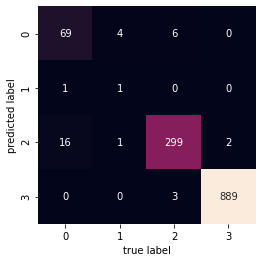

In [ ]:
import seaborn as sns
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
feature_importance = pd.DataFrame({'feature': feature_train.columns, 'feature_importance': forest_diag.feature_importances_})
feature_importance = feature_importance.sort_values('feature_importance', ascending=False).reset_index(drop=True)
feature_importance

,feature,feature_importance
0,points,0.497011
1,raceId,0.131661
2,grid,0.123168
3,driverId,0.095789
4,constructorId,0.048717
5,milliseconds,0.042124
6,circuitId,0.030818
7,laps,0.030712


Text(0.5, 1.0, 'Feature Importance')

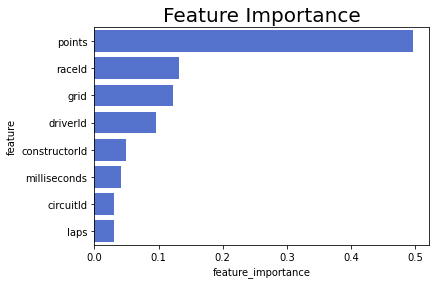

In [ ]:
sns.barplot(x = 'feature_importance', y='feature', data=feature_importance, orient='h', color='royalblue').set_title('Feature Importance', fontsize = 20)

Variância

In [ ]:
variance = accuracy_train - accuracy_test
variance

0.025561580170410547

Viés

In [ ]:
bias = 1 - 0.02 - accuracy_test
bias

0.005561580170410529

In [ ]:
print(accuracy_test)
print(accuracy_train)

0.9744384198295895
1.0
